## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    HuberRegressor,
    LinearRegression,
    RANSACRegressor,
    TheilSenRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.neighbors import LocalOutlierFactor

from pyod.models.knn import KNN

from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

In [2]:
metric = 'salinity'

df = pd.read_parquet('../Peterson Flow Through/Merges/PETERSON_FINAL.parquet')#.sample(n=100000)
df.datetime = pd.to_datetime(df.datetime)
df = df[df.file == '14322dat.txt']
print(len(df))

8760


Before:

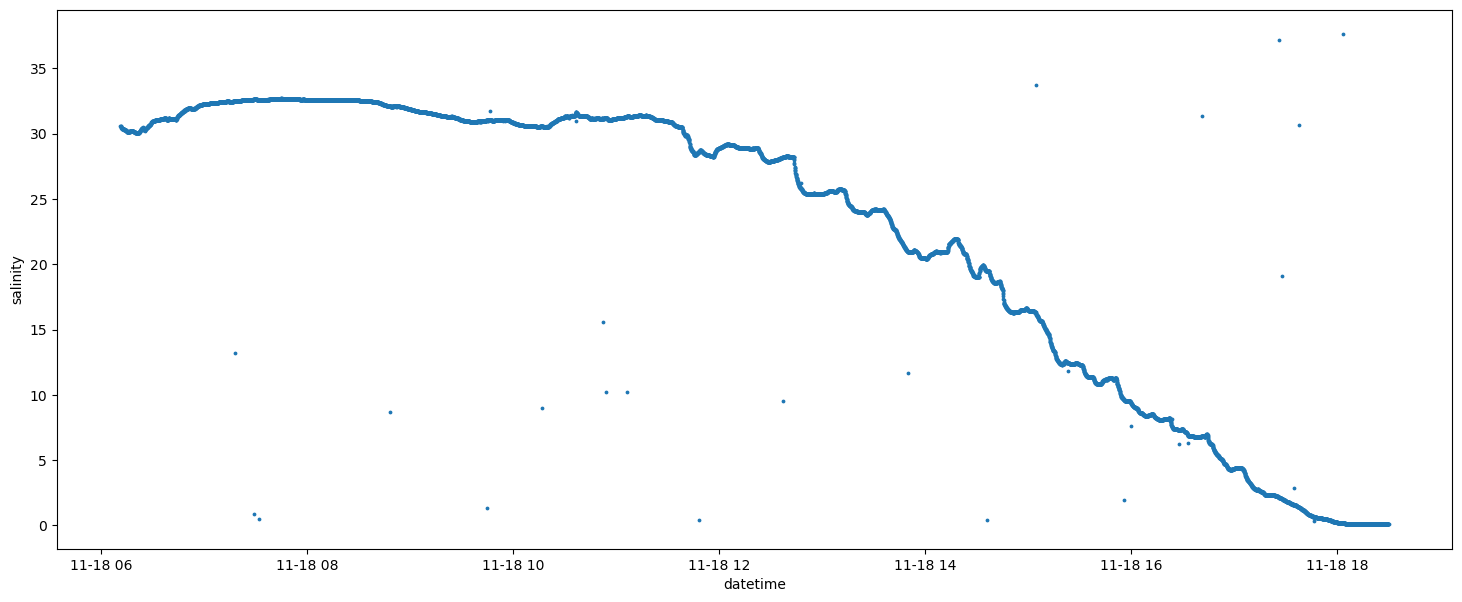

In [3]:
df.plot('datetime', metric, kind='scatter', s=3)
plt.show()

## Z-SCORE

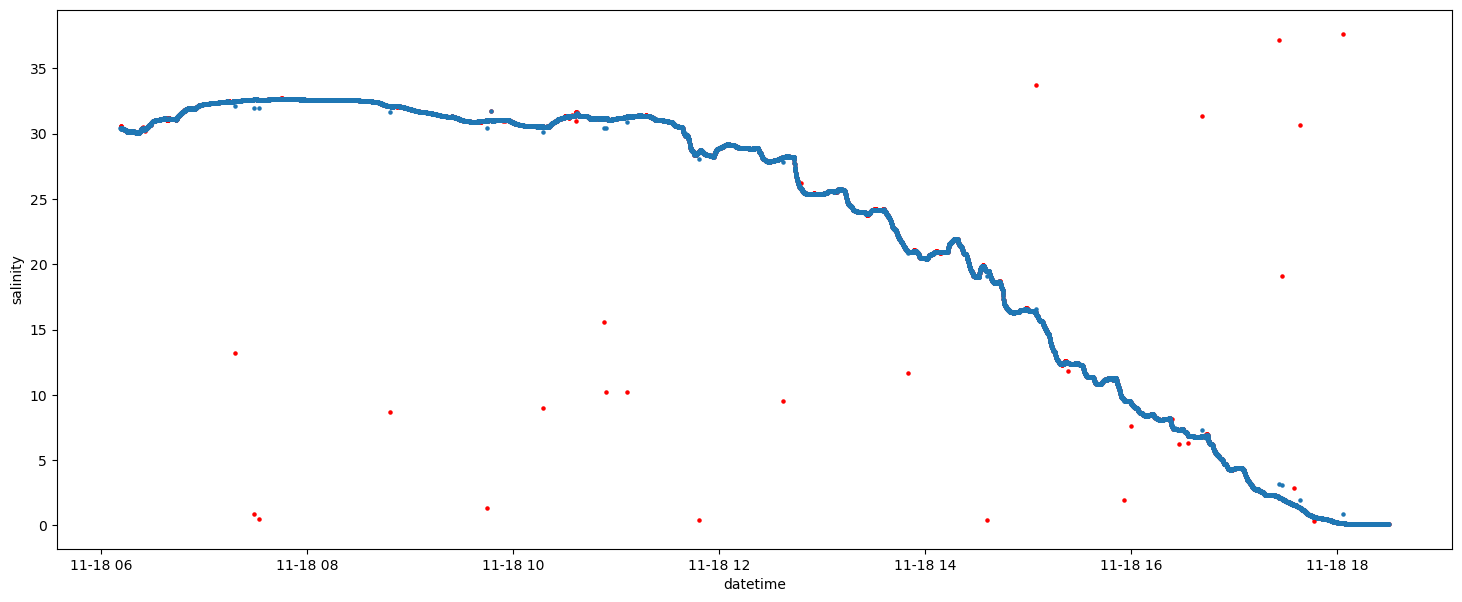

In [4]:
df2 = df.copy()
original = df.copy()

roll = df2[metric].rolling(window=50, min_periods=1, center=True)
avg = roll.mean()
std = roll.std(ddof=0)
z = df2[metric].sub(avg).div(std)
m = z.between(-1, 1)
df2[metric] = df2[metric].where(m, avg)

ax = original.plot('datetime', metric, kind='scatter', s=5, c='red')        
df2.plot(ax=ax, x='datetime', y=metric, kind='scatter', s=5)
plt.show()
plt.show()

## RANSAC
Possibly useful for the actual station regression. RANSAC will mitigate the effect of any remaining outliers after data cleaning, assuming the relationship from station data to flow through data is linear

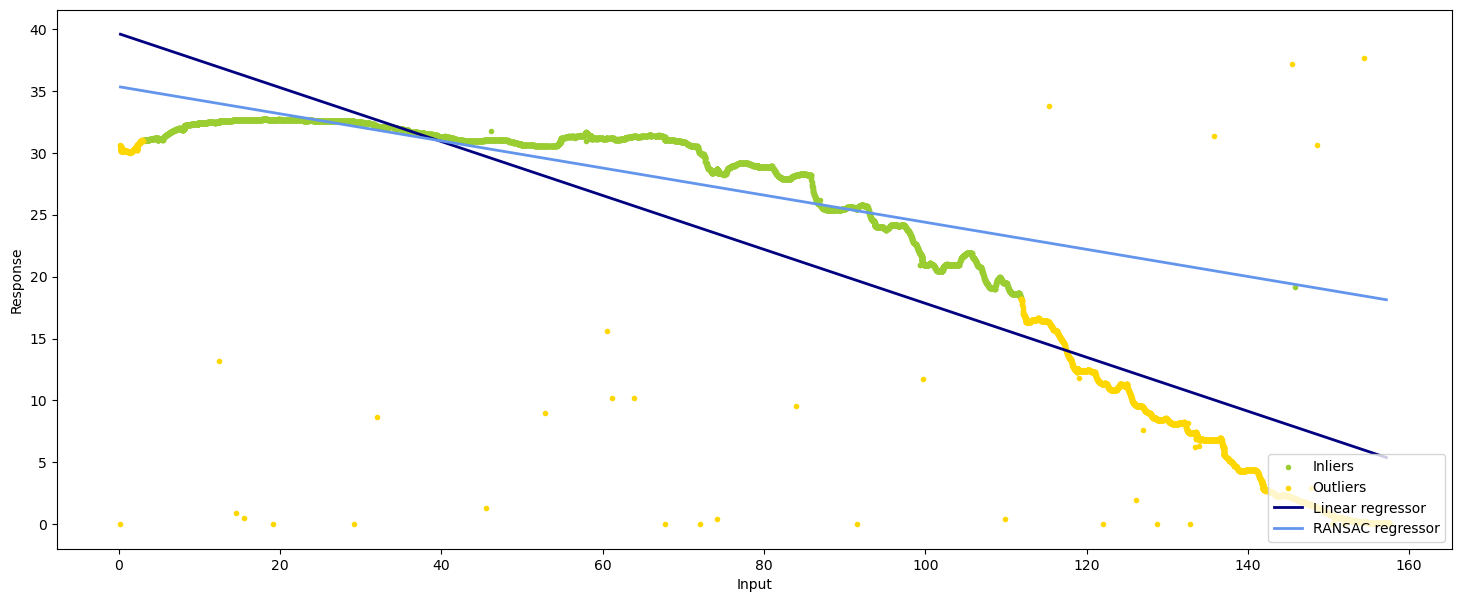

In [15]:
X = df.d_from_start.to_numpy().reshape(-1, 1)
y = df.salinity.fillna(0).to_numpy().reshape(-1, 1)

linear = linear_model.LinearRegression()
linear.fit(X, y)

ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = linear.predict(line_X)
line_y_ransac = ransac.predict(line_X)

lw = 2
plt.scatter(
    X[inlier_mask], y[inlier_mask], color="yellowgreen", marker=".", label="Inliers"
)
plt.scatter(
    X[outlier_mask], y[outlier_mask], color="gold", marker=".", label="Outliers"
)
plt.plot(line_X, line_y, color="navy", linewidth=lw, label="Linear regressor")
plt.plot(
    line_X,
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)
plt.legend(loc="lower right")
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

## Local Outliers Factor
Density based function, doesn't seem to be working on this data

[-450000001.0000001, -20000000.999996018, -1.0, -1.0, -1.0, -1.2621902351478584, -1.0122133598741416, -1.003389830496979, -0.9999999999999994, -1.0000000000000058, -1.0000000000000058, -1.008620689625439, -1.0189362944993705, -0.9849717514626264, -0.9849717514626264, -1.0027495291770314, -1.0027495291770314, -1.0027495291770314, -1.0490936478489417, -1.0490936478489417, -0.9988518954266153, -0.9988518954266153, -0.9988518954266153, -0.9988518954266153, -0.9988518954266153, -0.9988518954266153, -0.9631444945304048, -0.9631444945304048, -0.9873871771384547, -0.9631444945304048, -0.9724885949161243, -1.0116465906159142, -1.0440844386616432, -1.0116465906159142, -1.0116465906159142, -1.0440844386616432, -1.0440844386616432, -1.094687952488687, -1.3855916130098744, -1.1782099924485636, -1.0948051941378298, -0.8751039817042369, -1.1257142848326214, -0.980555555603066, -1.137007109691442, -1.0794505487358728, -0.8972689082078646, -0.8972689082078646, -0.9728287842800949, -0.9728287842800949, 

<Axes: xlabel='datetime', ylabel='salinity'>

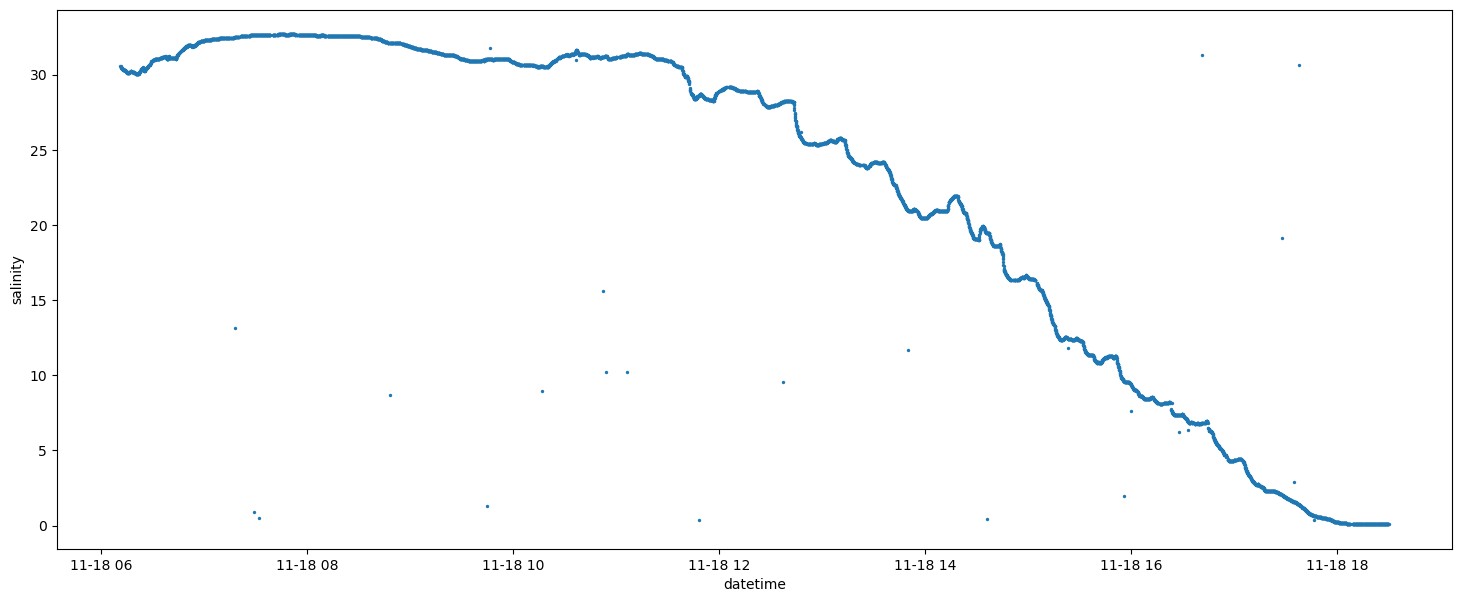

In [107]:
df3 = df.copy().reset_index()

X = df.salinity.fillna(0).to_numpy().reshape(-1, 1)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0001)
mask = lof.fit(X).negative_outlier_factor_.tolist()
print(mask)
print(len(df3))
for i, row in df3.iterrows():
    if mask[i] < -1000000:
        df3 = df3.drop(index=i)
        #print(f'dropped: {i}')

print(len(df3))
df3.plot('datetime', metric, kind='scatter', s=2)

## Interquartile Range
Too difficult to tune hyper parameters for unequally distributed data<br>
https://www.researchgate.net/publication/374567172_Analysis_of_Ionospheric_Anomalies_before_the_Tonga_Volcanic_Eruption_on_15_January_2022

<Axes: xlabel='datetime', ylabel='salinity'>

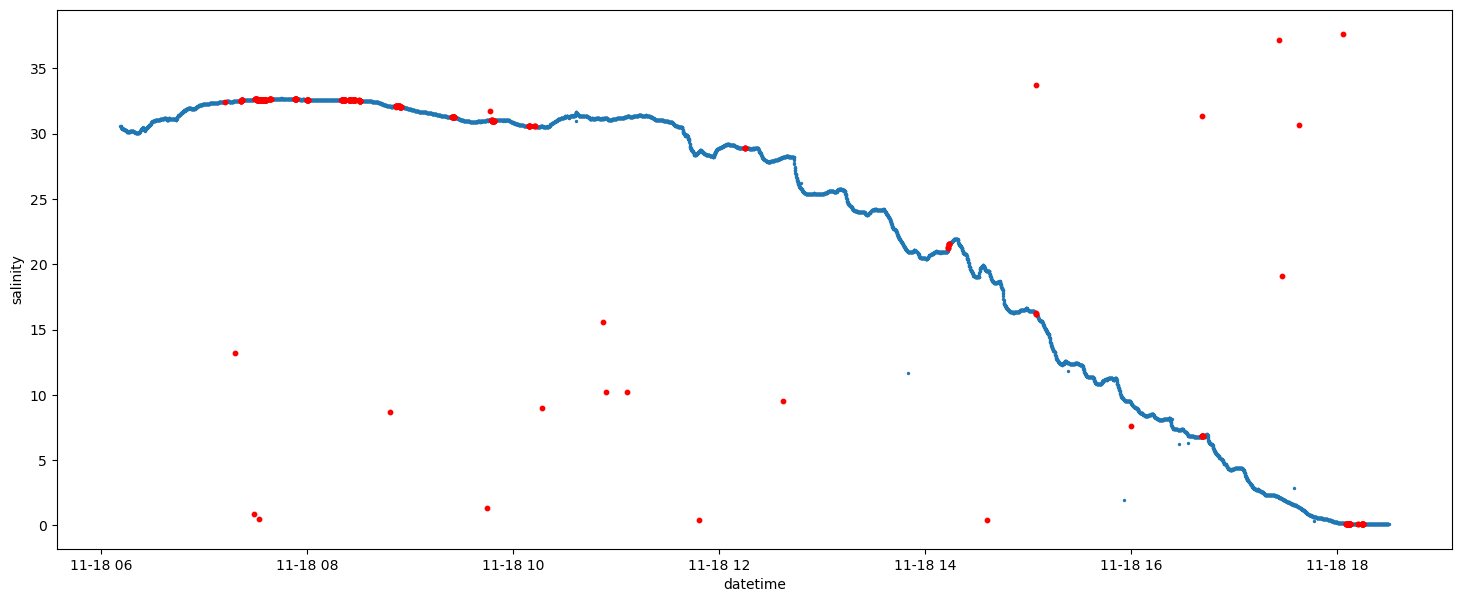

In [104]:
df4 = df.copy()

win_size = 50
avg = df4.salinity.rolling(win_size).mean()
q1 = df4.salinity.rolling(win_size).quantile(0.25)
q3 = df4.salinity.rolling(win_size).quantile(0.75)
iqr = q3 - q1

df4['ulim'] = avg + (25 * iqr)
df4['llim'] = avg - (25 * iqr)

outliers = df4[(df4.salinity > df4.ulim) | (df4.salinity < df4.llim)]
df4 = df4[~(df4.salinity > df4.ulim) | (df4.salinity < df4.llim)]

ax = df4.plot('datetime', metric, kind='scatter', s=2)
outliers.plot(ax=ax, x='datetime', y=metric, kind='scatter', s=10, c='red')

## Nearest Neighbor (Custom)
Custom method, still looking for verification on this one. Based on the fact that anamolies are almost always a single incorrect point. This method only works on data with small variations per unit of time, and where outliers are single data points rather than sequential. This is essentially a kth-NN solution with k=1<br>
https://proceedings.neurips.cc/paper_files/paper/2019/file/805163a0f0f128e473726ccda5f91bac-Paper.pdf<br><br>

"In this paper we have presented empirical evidence, based on simulated and real-life benchmark
datasets, that NN-based methods show very good performance at identifying anomalous instances"

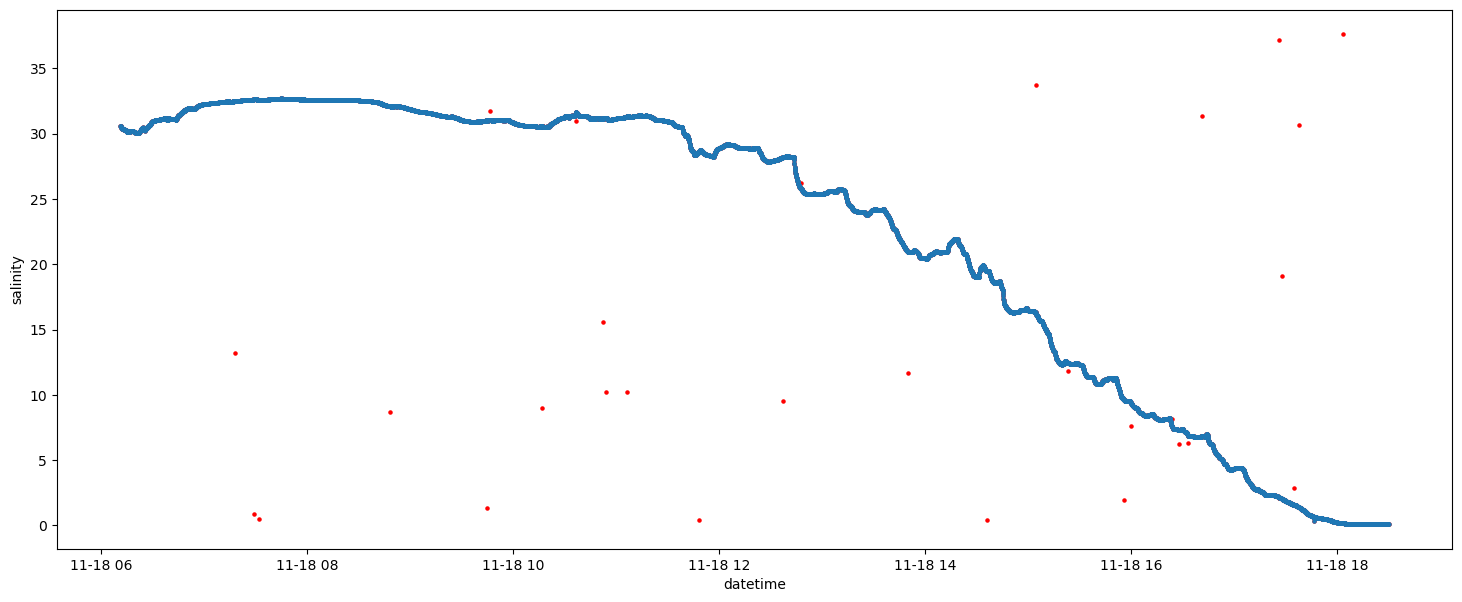

In [5]:
df5 = df.copy().reset_index()
original = df.copy()
metric = 'salinity'

# We drop any value whose difference is > than N% the difference between the min/max values of our data
# 1-5% seems to be a solid threshold
thold = 0.01

max = df5[metric].max()
min = df5[metric].min()
prev = diff = 0
for i, row in df5.iterrows():
    if i == 0: 
        prev = row[metric]
        continue

    diff = abs(prev - row[metric])
    prev = row[metric]

    if diff > ((max - min) * thold):
        df5.drop(index=i, inplace=True)
        #print(f'dropped: {i} -- {row.salinity} -- {diff}')

ax = original.plot('datetime', metric, kind='scatter', s=5, c='red')        
df5.plot(ax=ax, x='datetime', y=metric, kind='scatter', s=5)
plt.show()

## K-Nearest Neighbors (KNN)
https://pyod.readthedocs.io/en/latest/#id19

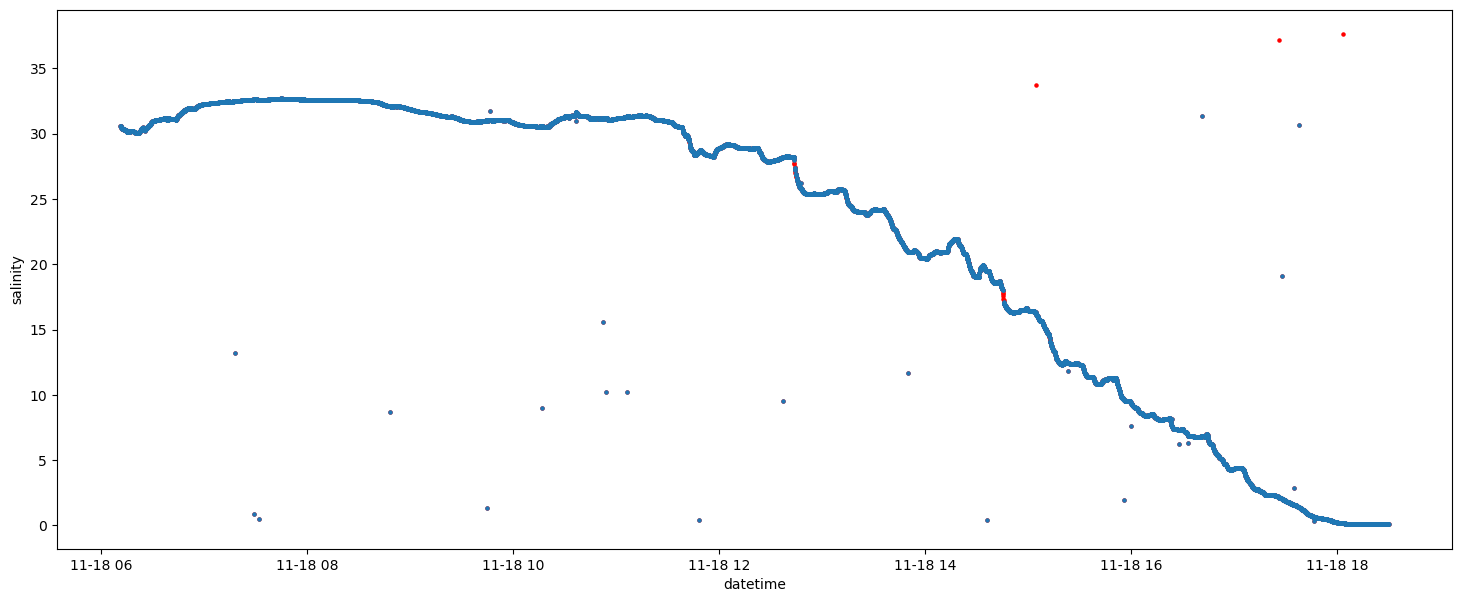

In [22]:
df6 = df.copy().reset_index()
original = df.copy()
metric = 'salinity'

X = df6[[metric]].fillna(0)
knn = KNN(contamination=0.01, method='median', n_neighbors=3)
knn.fit(X)
predicted = pd.Series(knn.predict(X), index=X.index)
df6 = df6[predicted == 0]

ax = original.plot('datetime', metric, kind='scatter', s=5, c='red')        
df6.plot(ax=ax, x='datetime', y=metric, kind='scatter', s=5)
plt.show()